In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm
import os

In [54]:
meta_df = pd.read_csv('../../Data/battery_rul/metadata.csv')

In [61]:
file_list = glob.glob('../../Data/battery_rul/data/*.csv')

In [157]:
discharge_df = pd.DataFrame()
charge_df = pd.DataFrame()

folder_path = '../../Data/battery_rul//data/'

# Initialize variables to track discharge and charge cycles
discharge_cycle, charge_cycle = 0, 0
prev_battery_id = None

for index, row in tqdm(meta_df.iterrows()):
    file_name = row['filename']
    battery_id = row['battery_id']
    
    # Check if battery ID has changed
    if battery_id != prev_battery_id:
        discharge_cycle, charge_cycle = 0, 0
        prev_battery_id = battery_id
    
    file_path = os.path.join(folder_path, file_name)
    file_df = pd.read_csv(file_path)
    
    file_df['battery_id'] = battery_id
    if row['type'] != 'impedance':
        final_time = file_df.Time.iloc[-1]
        file_df['RUL'] = final_time - file_df['Time']
    
    if row['type'] == 'discharge':
        discharge_cycle += 1
        file_df['cycle'] = discharge_cycle
        discharge_df = pd.concat([discharge_df, file_df], ignore_index=True)
    elif row['type'] == 'charge':
        charge_cycle += 1
        file_df['cycle'] = charge_cycle
        charge_df = pd.concat([charge_df, file_df], ignore_index=True)

print("Discharge DataFrame:")
print(discharge_df.head())

print("\nCharge DataFrame:")
print(charge_df.head())


7565it [03:20, 37.66it/s] 

Discharge DataFrame:
   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.246711          0.000252              6.212696        0.0002   
1          4.246764         -0.001411              6.234019        0.0002   
2          4.039277         -0.995093              6.250255        1.0000   
3          4.019506         -0.996731              6.302176        1.0000   
4          4.004763         -0.992845              6.361645        1.0000   

   Voltage_load    Time battery_id       RUL  cycle  
0         0.000   0.000      B0047  6436.141      1  
1         4.262   9.360      B0047  6426.781      1  
2         3.465  23.281      B0047  6412.860      1  
3         3.451  36.406      B0047  6399.735      1  
4         3.438  49.625      B0047  6386.516      1  

Charge DataFrame:
   Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
0          3.486189          0.001417              5.990142         -0.0006   
1          3.74

In [158]:
# charge_df.to_csv('../../Data/battery_rul/charge_data.csv', index=False)
# discharge_df.to_csv('../../Data/battery_rul/discharge_data.csv', index=False)

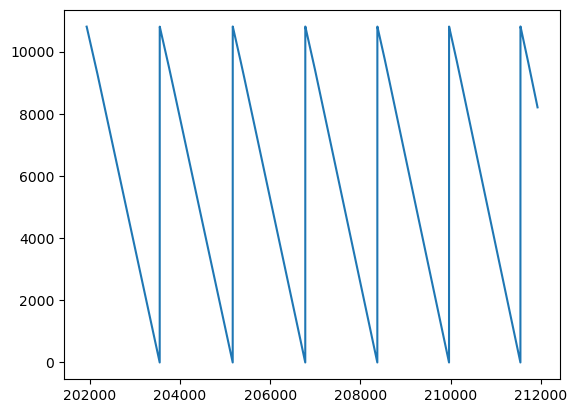

In [203]:
plt.plot(charge_df[(charge_df['battery_id'] == charge_df['battery_id'].unique()[2])]['RUL'][:10000])

In [190]:
df_c = charge_df[(charge_df['battery_id'] == charge_df['battery_id'].unique()[2]) & (charge_df['cycle']==1)].reset_index(drop=True)

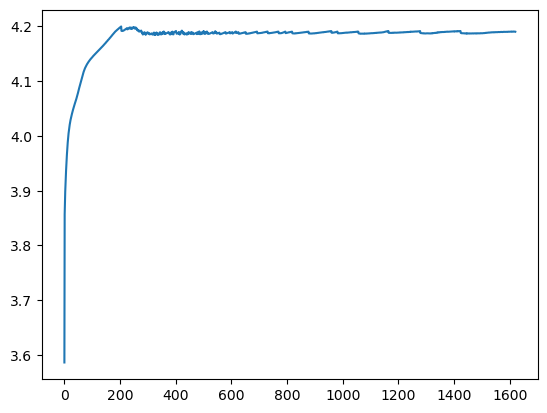

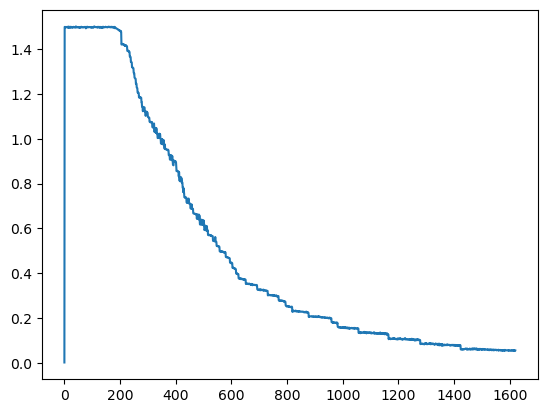

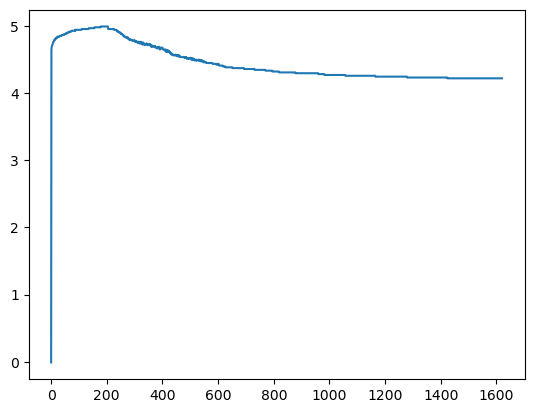

In [191]:
plt.plot(df_c['Voltage_measured'])
plt.show()

plt.plot(df_c['Current_measured'])
plt.show()

plt.plot(df_c['Voltage_charge'])
plt.show()

In [178]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [192]:
df_c

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,battery_id,RUL,cycle
0,3.586172,0.001153,6.321221,0.0001,-0.010,0.000,B0048,10803.313,1
1,3.856847,1.499385,6.327132,1.5017,4.651,2.594,B0048,10800.719,1
2,3.881805,1.498353,6.327440,1.5017,4.689,8.922,B0048,10794.391,1
3,3.898262,1.499098,6.338233,1.5017,4.702,15.234,B0048,10788.079,1
4,3.912357,1.499174,6.349255,1.5017,4.715,21.516,B0048,10781.797,1
...,...,...,...,...,...,...,...,...,...
1616,4.190679,0.055073,6.001328,0.0556,4.221,10776.438,B0048,26.875,1
1617,4.190599,0.054546,6.000192,0.0551,4.221,10783.156,B0048,20.157,1
1618,4.190679,0.053818,6.003824,0.0556,4.221,10789.875,B0048,13.438,1
1619,4.190609,0.055499,6.027659,0.0556,4.221,10796.578,B0048,6.735,1


In [193]:
y = df_c['RUL']
x = df_c.drop(['RUL', 'Time', 'battery_id', 'cycle'], axis=1)

In [194]:
trdat = x.values[:int(x.shape[0]*0.8), :]
tsdat = x.values[int(x.shape[0]*0.8):, :]

trScore_arr = np.zeros([trdat.shape[0], trdat.shape[1]])
tsScore_arr = np.zeros([tsdat.shape[0], trdat.shape[1]])

lr = LinearRegression()

input_idx = np.arange(trdat.shape[1]).tolist()
for idx in input_idx:
    input_idx = np.arange(trdat.shape[1]).tolist()
    input_idx.remove(idx)
    
    lr.fit(trdat[:,input_idx], trdat[:,idx])
    
    # 각 변수 별 train/test score
    trScore = lr.predict(trdat[:,input_idx])
    tsScore = lr.predict(tsdat[:,input_idx])
    
    trScore_arr[:,idx] = trScore
    tsScore_arr[:,idx] = tsScore

# 각 변수 별 통합 train/test score
integrated_trScore = np.sqrt(np.sum(trScore_arr**2, axis=1))
integrated_tsScore = np.sqrt(np.sum(tsScore_arr**2, axis=1))

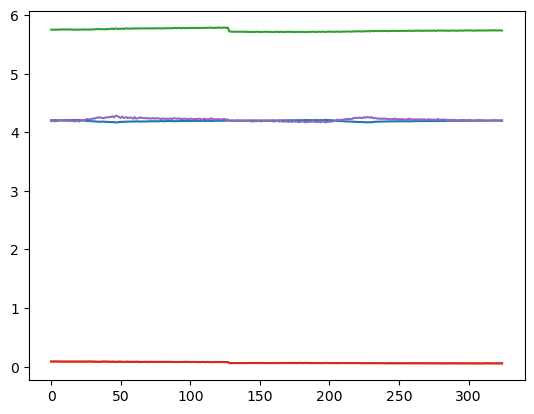

In [195]:
plt.plot(tsScore_arr[:2000])

In [196]:
l2norm_trScore = np.sqrt(np.sum(trScore_arr**2, axis=1))
tr_degScore = np.cumsum(l2norm_trScore) / np.arange(1,len(trdat)+1,1)

l2norm_tsScore = np.sqrt(np.sum(tsScore_arr**2, axis=1))
ts_degScore = np.cumsum(l2norm_tsScore) / np.arange(1,len(tsdat)+1,1)

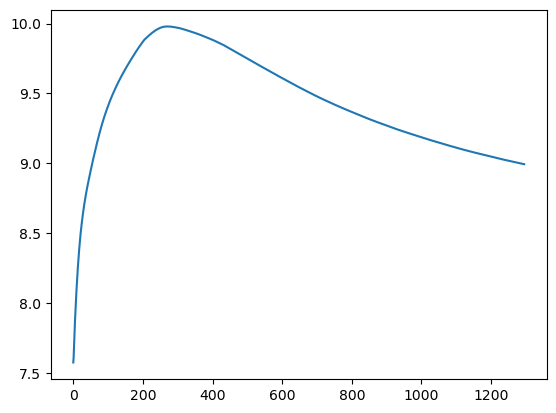

In [197]:
plt.plot(tr_degScore)